> The log error is defined as: logerror=log(Zestimate)−log(SalePrice) In plain English, logerror helps Zillow identify where their algorithm falls short.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, f_oneway, kruskal
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import os
import env
from env import host, user, password

def get_connection(db):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def get_zillow_data():
    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        df = pd.read_sql("""SELECT 
                        p.*, 
                        ac.airconditioningdesc,
                        ast.architecturalstyletypeid, 
                        ast.architecturalstyledesc,
                        bct.buildingclasstypeid, 
                        bct.buildingclassdesc,
                        hst.heatingorsystemtypeid, 
                        hst.heatingorsystemdesc,
                        pred.logerror, 
                        pred.transactiondate,
                        plt.propertylandusetypeid, 
                        plt.propertylandusedesc,
                        st.storytypeid, 
                        st.storydesc,
                        tct.typeconstructiontypeid, 
                        tct.typeconstructiondesc
                        FROM properties_2017 p
                        JOIN predictions_2017 pred ON p.parcelid = pred.parcelid
                        LEFT JOIN airconditioningtype ac ON p.airconditioningtypeid = ac.airconditioningtypeid
                        LEFT JOIN architecturalstyletype ast ON p.architecturalstyletypeid = ast.architecturalstyletypeid
                        LEFT JOIN buildingclasstype bct ON p.buildingclasstypeid = bct.buildingclasstypeid
                        LEFT JOIN heatingorsystemtype hst ON p.heatingorsystemtypeid = hst.heatingorsystemtypeid
                        LEFT JOIN propertylandusetype plt ON p.propertylandusetypeid = plt.propertylandusetypeid
                        LEFT JOIN storytype st ON p.storytypeid = st.storytypeid
                        LEFT JOIN typeconstructiontype tct ON p.typeconstructiontypeid = tct.typeconstructiontypeid;
                        """,get_connection('zillow'))

        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename)
        
        # Return the dataframe to the calling code
        return df

In [4]:
df = get_zillow_data()

In [5]:
df

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,heatingorsystemtypeid.1,heatingorsystemdesc,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,storytypeid.1,storydesc,typeconstructiontypeid.1,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,0.025595,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,0.055619,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,NaN,NaN,0.005383,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
3,3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,2.0,Central,-0.103410,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
4,4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,2.0,Central,0.006940,2017-01-01,266.0,Condominium,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77609,77609,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,2.0,Central,0.020615,2017-09-20,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77610,77610,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,NaN,NaN,0.013209,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77611,77611,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,2.0,Central,0.037129,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77612,77612,1187175,12826780,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,2.0,Central,0.007204,2017-09-25,261.0,Single Family Residential,NaN,NaN,NaN,NaN


In [6]:
df.columns

Index(['Unnamed: 0', 'id', 'parcelid', 'airconditioningtypeid',
       'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbu

In [7]:
data = df

In [8]:
data

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,heatingorsystemtypeid.1,heatingorsystemdesc,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,storytypeid.1,storydesc,typeconstructiontypeid.1,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,0.025595,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,0.055619,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,NaN,NaN,0.005383,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
3,3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,2.0,Central,-0.103410,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
4,4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,2.0,Central,0.006940,2017-01-01,266.0,Condominium,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77609,77609,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,2.0,Central,0.020615,2017-09-20,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77610,77610,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,NaN,NaN,0.013209,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77611,77611,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,2.0,Central,0.037129,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77612,77612,1187175,12826780,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,2.0,Central,0.007204,2017-09-25,261.0,Single Family Residential,NaN,NaN,NaN,NaN


In [9]:
# Define a function to split homes into newer and older based on a cutoff year
def split_new_old_homes(data, cutoff_year):
    newer_homes = data[data['yearbuilt'] > cutoff_year]
    older_homes = data[data['yearbuilt'] <= cutoff_year]
    return newer_homes, older_homes

# Split homes into newer and older homes using a cutoff year (e.g., 2000)
newer_homes, older_homes = split_new_old_homes(data, 2000)

In [10]:
newer_homes, older_homes = split_new_old_homes(data, 2000)

In [11]:
df

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,heatingorsystemtypeid.1,heatingorsystemdesc,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,storytypeid.1,storydesc,typeconstructiontypeid.1,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,0.025595,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,0.055619,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,NaN,NaN,0.005383,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
3,3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,2.0,Central,-0.103410,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN
4,4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,2.0,Central,0.006940,2017-01-01,266.0,Condominium,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77609,77609,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,2.0,Central,0.020615,2017-09-20,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77610,77610,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,NaN,NaN,0.013209,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77611,77611,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,2.0,Central,0.037129,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN
77612,77612,1187175,12826780,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,2.0,Central,0.007204,2017-09-25,261.0,Single Family Residential,NaN,NaN,NaN,NaN


In [12]:
import pandas as pd
import numpy as np
import wrangle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, kruskal, f_oneway

# Add home_age column to the DataFrame
data['home_age'] = 2023 - data['yearbuilt']

# Define newer and older homes based on the median age
median_age = data['home_age'].median()
newer_homes = data[data['home_age'] <= median_age]
older_homes = data[data['home_age'] > median_age]

In [13]:
data

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,heatingorsystemdesc,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,storytypeid.1,storydesc,typeconstructiontypeid.1,typeconstructiondesc,home_age
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,0.025595,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN,25.0
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,0.055619,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN,56.0
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,NaN,0.005383,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN,61.0
3,3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,Central,-0.103410,2017-01-01,261.0,Single Family Residential,NaN,NaN,NaN,NaN,53.0
4,4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,Central,0.006940,2017-01-01,266.0,Condominium,NaN,NaN,NaN,NaN,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77609,77609,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,Central,0.020615,2017-09-20,261.0,Single Family Residential,NaN,NaN,NaN,NaN,83.0
77610,77610,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,NaN,0.013209,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN,59.0
77611,77611,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,Central,0.037129,2017-09-21,261.0,Single Family Residential,NaN,NaN,NaN,NaN,69.0
77612,77612,1187175,12826780,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,Central,0.007204,2017-09-25,261.0,Single Family Residential,NaN,NaN,NaN,NaN,68.0


In [14]:
columns_to_drop = ['garagecarcnt','garagetotalsqft','heatingorsystemdesc','fireplacecnt','buildingqualitytypeid','finishedsquarefeet12','finishedsquarefeet50','finishedsquarefeet6','taxdelinquencyflag','taxdelinquencyyear','airconditioningdesc', 'architecturalstyletypeid.1',	'heatingorsystemtypeid.1','Unnamed: 0','finishedsquarefeet13','finishedsquarefeet15','architecturalstyledesc', 'buildingclasstypeid.1','buildingclassdesc','decktypeid','finishedfloor1squarefeet','storytypeid.1', 'storydesc', 'typeconstructiontypeid.1', 'typeconstructiondesc', 'buildingclasstypeid', 'architecturalstyletypeid', 'basementsqft', 'airconditioningtypeid']
data = data.drop(columns_to_drop, axis=1)

In [15]:
data = wrangle.drop_missing_data(data, 0.7)

In [16]:
data

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
0,1727539,14297519,3.5,4.0,3.5,3100.0,6059.0,3.0,NaN,NaN,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,261.0,Single Family Residential,25.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,6111.0,1.0,NaN,NaN,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,261.0,Single Family Residential,56.0
2,11677,14186244,2.0,3.0,2.0,1243.0,6059.0,2.0,NaN,NaN,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,261.0,Single Family Residential,61.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,NaN,2.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,NaN,2.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77609,673515,11000655,2.0,2.0,2.0,1286.0,6037.0,2.0,NaN,2.0,...,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,261.0,Single Family Residential,83.0
77610,2968375,17239384,2.0,4.0,2.0,1612.0,6111.0,2.0,NaN,NaN,...,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,261.0,Single Family Residential,59.0
77611,1843709,12773139,1.0,3.0,1.0,1032.0,6037.0,1.0,NaN,2.0,...,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,261.0,Single Family Residential,69.0
77612,1187175,12826780,2.0,3.0,2.0,1762.0,6037.0,2.0,NaN,2.0,...,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,2017-09-25,261.0,Single Family Residential,68.0


In [17]:
# Assuming 'transactiondate' is the column containing the transaction dates
data['transactiondate'] = pd.to_datetime(data['transactiondate'])

# Keep only rows with transaction dates from prediction 2017
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-12-31')

data_2017 = data[(data['transactiondate'] >= start_date) & (data['transactiondate'] <= end_date)]

In [18]:
# Find the maximum transaction date
max_transaction_date = data['transactiondate'].max()

# Filter the rows that have the maximum transaction date
data_latest_transactions = data[data['transactiondate'] == max_transaction_date]

data_latest_transactions

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
77613,2455685,13083743,2.0,3.0,2.0,1050.0,6037.0,2.0,NaN,7.0,...,259334.0,2016.0,182216.0,3345.78,6.037408e+13,-0.197755,2018-05-25,261.0,Single Family Residential,63.0


In [19]:
data_2017

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
0,1727539,14297519,3.5,4.0,3.5,3100.0,6059.0,3.0,NaN,NaN,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,261.0,Single Family Residential,25.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,6111.0,1.0,NaN,NaN,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,261.0,Single Family Residential,56.0
2,11677,14186244,2.0,3.0,2.0,1243.0,6059.0,2.0,NaN,NaN,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,261.0,Single Family Residential,61.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,NaN,2.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,NaN,2.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,2864704,10833991,3.0,3.0,3.0,1741.0,6037.0,3.0,NaN,2.0,...,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,266.0,Condominium,43.0
77609,673515,11000655,2.0,2.0,2.0,1286.0,6037.0,2.0,NaN,2.0,...,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,261.0,Single Family Residential,83.0
77610,2968375,17239384,2.0,4.0,2.0,1612.0,6111.0,2.0,NaN,NaN,...,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,261.0,Single Family Residential,59.0
77611,1843709,12773139,1.0,3.0,1.0,1032.0,6037.0,1.0,NaN,2.0,...,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,261.0,Single Family Residential,69.0


In [20]:
data_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77579 entries, 0 to 77612
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            77579 non-null  int64         
 1   parcelid                      77579 non-null  int64         
 2   bathroomcnt                   77579 non-null  float64       
 3   bedroomcnt                    77579 non-null  float64       
 4   calculatedbathnbr             76963 non-null  float64       
 5   calculatedfinishedsquarefeet  77378 non-null  float64       
 6   fips                          77579 non-null  float64       
 7   fullbathcnt                   76963 non-null  float64       
 8   hashottuborspa                1539 non-null   float64       
 9   heatingorsystemtypeid         49571 non-null  float64       
 10  latitude                      77579 non-null  float64       
 11  longitude                   

In [21]:
data_2017 = wrangle.drop_missing_data(data_2017, 0.9)

In [22]:
data_2017

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
0,1727539,14297519,3.5,4.0,3.5,3100.0,6059.0,3.0,NaN,NaN,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,261.0,Single Family Residential,25.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,6111.0,1.0,NaN,NaN,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,261.0,Single Family Residential,56.0
2,11677,14186244,2.0,3.0,2.0,1243.0,6059.0,2.0,NaN,NaN,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,261.0,Single Family Residential,61.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,NaN,2.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,NaN,2.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,2864704,10833991,3.0,3.0,3.0,1741.0,6037.0,3.0,NaN,2.0,...,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,266.0,Condominium,43.0
77609,673515,11000655,2.0,2.0,2.0,1286.0,6037.0,2.0,NaN,2.0,...,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,261.0,Single Family Residential,83.0
77610,2968375,17239384,2.0,4.0,2.0,1612.0,6111.0,2.0,NaN,NaN,...,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,261.0,Single Family Residential,59.0
77611,1843709,12773139,1.0,3.0,1.0,1032.0,6037.0,1.0,NaN,2.0,...,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,261.0,Single Family Residential,69.0


In [23]:
import numpy as np

In [24]:
# Calculate the mean of non-null counts for all rows
mean_non_null_count = data_2017 .notnull().sum(axis=1).mean()

In [25]:
mean_non_null_count

33.03450676085023

In [26]:
# Drop rows with non-null counts below the mean
data_filtered = data_2017[data_2017 .notnull().sum(axis=1) >= mean_non_null_count]

In [27]:
data_2017 = wrangle.drop_rows_with_high_nans(data_2017, 0.9)

In [28]:
data_2017

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
0,1727539,14297519,3.5,4.0,3.5,3100.0,6059.0,3.0,NaN,NaN,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,261.0,Single Family Residential,25.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,6111.0,1.0,NaN,NaN,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,261.0,Single Family Residential,56.0
2,11677,14186244,2.0,3.0,2.0,1243.0,6059.0,2.0,NaN,NaN,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,261.0,Single Family Residential,61.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,NaN,2.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,NaN,2.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,2864704,10833991,3.0,3.0,3.0,1741.0,6037.0,3.0,NaN,2.0,...,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,266.0,Condominium,43.0
77609,673515,11000655,2.0,2.0,2.0,1286.0,6037.0,2.0,NaN,2.0,...,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,261.0,Single Family Residential,83.0
77610,2968375,17239384,2.0,4.0,2.0,1612.0,6111.0,2.0,NaN,NaN,...,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,261.0,Single Family Residential,59.0
77611,1843709,12773139,1.0,3.0,1.0,1032.0,6037.0,1.0,NaN,2.0,...,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,261.0,Single Family Residential,69.0


In [29]:
data_2017

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
0,1727539,14297519,3.5,4.0,3.5,3100.0,6059.0,3.0,NaN,NaN,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,261.0,Single Family Residential,25.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,6111.0,1.0,NaN,NaN,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,261.0,Single Family Residential,56.0
2,11677,14186244,2.0,3.0,2.0,1243.0,6059.0,2.0,NaN,NaN,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,261.0,Single Family Residential,61.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,NaN,2.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,NaN,2.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,2864704,10833991,3.0,3.0,3.0,1741.0,6037.0,3.0,NaN,2.0,...,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,266.0,Condominium,43.0
77609,673515,11000655,2.0,2.0,2.0,1286.0,6037.0,2.0,NaN,2.0,...,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,261.0,Single Family Residential,83.0
77610,2968375,17239384,2.0,4.0,2.0,1612.0,6111.0,2.0,NaN,NaN,...,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,261.0,Single Family Residential,59.0
77611,1843709,12773139,1.0,3.0,1.0,1032.0,6037.0,1.0,NaN,2.0,...,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,261.0,Single Family Residential,69.0


In [30]:
import numpy as np

In [31]:
# Calculate the mean of non-null counts for all columns
mean_non_null_count = data_2017.notnull().sum().mean()

In [32]:
mean_non_null_count

54527.31914893617

In [33]:
# Identify columns with non-null counts below the mean
columns_to_drop = data_2017.columns[data_2017.notnull().sum() < mean_non_null_count]

In [34]:
columns_to_drop 

Index(['hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertyzoningdesc',
       'regionidneighborhood', 'storytypeid', 'threequarterbathnbr',
       'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'numberofstories', 'fireplaceflag'],
      dtype='object')

In [35]:
# Drop columns with non-null counts below the mean
filtered_data = data_2017.drop(columns=columns_to_drop)

In [36]:
filtered_data

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
0,1727539,14297519,3.5,4.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,261.0,Single Family Residential,25.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,261.0,Single Family Residential,56.0
2,11677,14186244,2.0,3.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,261.0,Single Family Residential,61.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,34185120.0,-118414640.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,2864704,10833991,3.0,3.0,3.0,1741.0,6037.0,3.0,34202400.0,-118502000.0,...,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,266.0,Condominium,43.0
77609,673515,11000655,2.0,2.0,2.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,...,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,261.0,Single Family Residential,83.0
77610,2968375,17239384,2.0,4.0,2.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,...,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,261.0,Single Family Residential,59.0
77611,1843709,12773139,1.0,3.0,1.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,...,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,261.0,Single Family Residential,69.0


In [37]:
data = filtered_data

In [38]:
# Remove rows with missing logerror or calculatedbathnbr values
data_clean = data.dropna(subset=['logerror', 'calculatedbathnbr'])

In [39]:
data = data_clean 

In [40]:
data

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
0,1727539,14297519,3.5,4.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,...,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,261.0,Single Family Residential,25.0
1,1387261,17052889,1.0,2.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,...,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,261.0,Single Family Residential,56.0
2,11677,14186244,2.0,3.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,...,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,261.0,Single Family Residential,61.0
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,34185120.0,-118414640.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,2864704,10833991,3.0,3.0,3.0,1741.0,6037.0,3.0,34202400.0,-118502000.0,...,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,266.0,Condominium,43.0
77609,673515,11000655,2.0,2.0,2.0,1286.0,6037.0,2.0,34245368.0,-118282383.0,...,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,261.0,Single Family Residential,83.0
77610,2968375,17239384,2.0,4.0,2.0,1612.0,6111.0,2.0,34300140.0,-118706327.0,...,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,261.0,Single Family Residential,59.0
77611,1843709,12773139,1.0,3.0,1.0,1032.0,6037.0,1.0,34040895.0,-118038169.0,...,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,261.0,Single Family Residential,69.0


In [41]:
data = data_filtered

In [42]:
data

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusetypeid.1,propertylandusedesc,home_age
3,2288172,12177905,3.0,4.0,3.0,2376.0,6037.0,3.0,NaN,2.0,...,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,261.0,Single Family Residential,53.0
4,1970746,10887214,3.0,3.0,3.0,1312.0,6037.0,3.0,NaN,2.0,...,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,266.0,Condominium,59.0
6,781532,12095076,3.0,4.0,3.0,2962.0,6037.0,3.0,NaN,2.0,...,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,261.0,Single Family Residential,73.0
9,1585097,11542646,3.0,2.0,3.0,1290.0,6037.0,3.0,NaN,2.0,...,371361.0,2016.0,220058.0,4557.32,6.037275e+13,-0.036763,2017-01-02,266.0,Condominium,43.0
10,1639362,11104527,3.0,4.0,3.0,2540.0,6037.0,3.0,NaN,2.0,...,430108.0,2016.0,158393.0,6103.36,6.037920e+13,0.005963,2017-01-02,261.0,Single Family Residential,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77601,1089830,10722237,1.0,2.0,1.0,868.0,6037.0,1.0,NaN,2.0,...,259738.0,2016.0,144804.0,3225.40,6.037134e+13,0.052630,2017-09-19,266.0,Condominium,46.0
77605,1642435,10858613,2.0,2.0,2.0,1261.0,6037.0,2.0,NaN,2.0,...,346788.0,2016.0,214889.0,4231.76,6.037141e+13,-0.075465,2017-09-19,266.0,Condominium,52.0
77606,1373391,10722691,2.0,3.0,2.0,1570.0,6037.0,2.0,NaN,2.0,...,72026.0,2016.0,25242.0,1000.70,6.037135e+13,0.081196,2017-09-19,261.0,Single Family Residential,65.0
77608,2864704,10833991,3.0,3.0,3.0,1741.0,6037.0,3.0,NaN,2.0,...,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,266.0,Condominium,43.0


In [43]:
data.describe()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,hashottuborspa,heatingorsystemtypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,propertylandusetypeid.1,home_age
count,3.116200e+04,3.116200e+04,31162.000000,31162.000000,31161.000000,31162.000000,31162.000000,31161.000000,975.0,28427.000000,...,137.0,3.115200e+04,3.116200e+04,31162.0,3.116200e+04,31161.000000,3.115300e+04,31162.000000,31162.000000,31161.000000
mean,1.492077e+06,1.201351e+07,2.388326,3.020377,2.388402,1875.645690,6040.749182,2.356600,1.0,3.420973,...,1.0,2.224925e+05,5.740533e+05,2016.0,3.516322e+05,6992.643589,6.041086e+13,0.012004,262.354246,58.808286
std,8.639134e+05,1.300337e+06,1.089315,1.121799,1.089249,1114.925915,13.542336,1.067904,0.0,2.337517,...,0.0,2.935118e+05,8.529646e+05,0.0,6.421572e+05,10055.332805,1.346029e+11,0.165005,3.143113,23.638218
min,3.490000e+02,1.071186e+07,0.000000,0.000000,1.000000,242.000000,6037.000000,1.000000,1.0,1.000000,...,1.0,1.320000e+02,1.000000e+03,2016.0,1.610000e+02,89.180000,6.037101e+13,-4.655420,246.000000,8.000000
25%,7.472235e+05,1.106770e+07,2.000000,2.000000,2.000000,1178.000000,6037.000000,2.000000,1.0,2.000000,...,1.0,9.400000e+04,2.235282e+05,2016.0,9.543325e+04,2875.880000,6.037143e+13,-0.029054,261.000000,42.000000
50%,1.492816e+06,1.171551e+07,2.000000,3.000000,2.000000,1571.000000,6037.000000,2.000000,1.0,2.000000,...,1.0,1.509755e+05,3.890000e+05,2016.0,2.189190e+05,4835.880000,6.037297e+13,0.006240,261.000000,59.000000
75%,2.244393e+06,1.252084e+07,3.000000,4.000000,3.000000,2235.000000,6037.000000,3.000000,1.0,7.000000,...,1.0,2.453180e+05,6.427968e+05,2016.0,4.088948e+05,7804.840000,6.037650e+13,0.040835,266.000000,73.000000
max,2.982167e+06,1.730086e+07,18.000000,14.000000,18.000000,21929.000000,6111.000000,18.000000,1.0,24.000000,...,1.0,9.164901e+06,4.906124e+07,2016.0,4.895220e+07,586639.300000,6.111009e+13,5.262999,269.000000,141.000000


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31162 entries, 3 to 77609
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            31162 non-null  int64         
 1   parcelid                      31162 non-null  int64         
 2   bathroomcnt                   31162 non-null  float64       
 3   bedroomcnt                    31162 non-null  float64       
 4   calculatedbathnbr             31161 non-null  float64       
 5   calculatedfinishedsquarefeet  31162 non-null  float64       
 6   fips                          31162 non-null  float64       
 7   fullbathcnt                   31161 non-null  float64       
 8   hashottuborspa                975 non-null    float64       
 9   heatingorsystemtypeid         28427 non-null  float64       
 10  latitude                      31162 non-null  float64       
 11  longitude                   

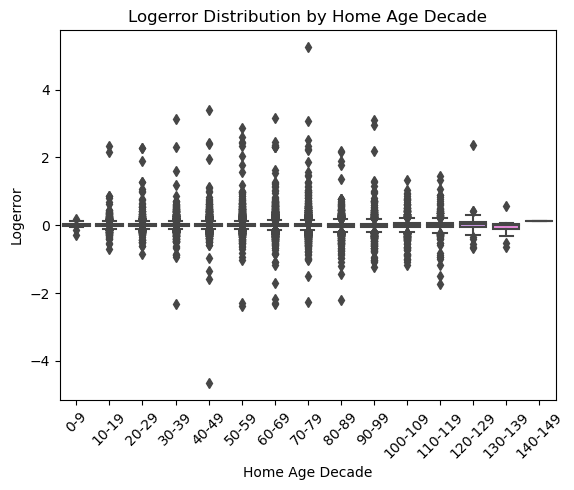

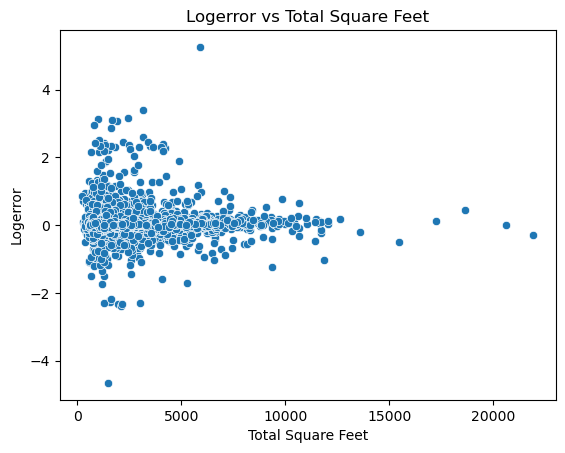

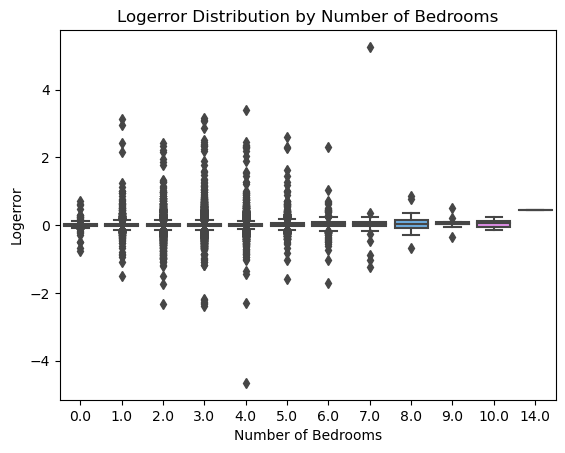

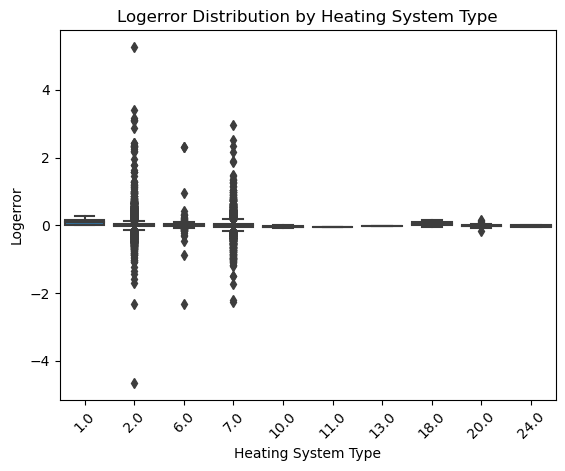

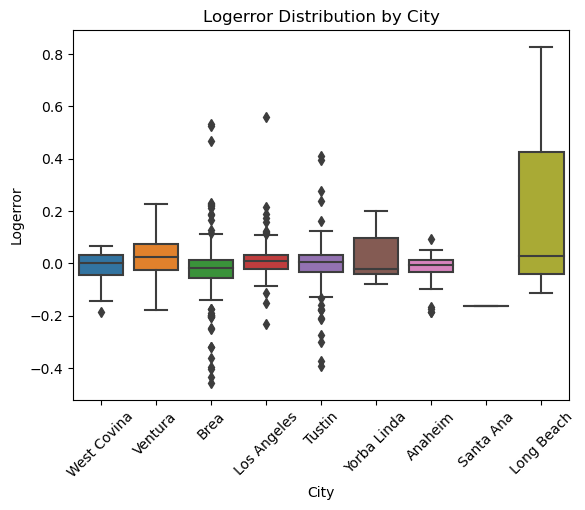

                                            Question  \
0  Is there a significant difference in logerror ...   
1  Is there a relationship between the size of a ...   
2  Do homes with more bedrooms have a higher loge...   
3  Is there a significant difference in logerror ...   
4  Are logerrors significantly different between ...   

                                     Null Hypothesis  \
0  There is no significant difference in logerror...   
1  There is no relationship between the size of a...   
2  There is no difference in logerror between hom...   
3  There is no significant difference in logerror...   
4  There is no significant difference in logerror...   

                              Alternative Hypothesis  \
0  There is a significant difference in logerror ...   
1  There is a relationship between the size of a ...   
2  Homes with more bedrooms have a higher logerro...   
3  There is a significant difference in logerror ...   
4  There is a significant difference in logerr

In [45]:
# Create a dictionary to map city ids to city names
city_map = {
    4406: 'Los Angeles',
    5465: 'Anaheim',
    5534: 'Brea',
    118994: 'Fullerton',
    118914: 'Long Beach',
    272578: 'Orange',
    396053: 'Santa Ana',
    396054: 'Tustin',
    396550: 'Ventura',
    396551: 'West Covina',
    396556: 'Yorba Linda'
}


# Define a function to conduct statistical tests and visualizations for each question
def evaluate_question(data, question, null_hypothesis, alternative_hypothesis):
    result = {
        'Question': question,
        'Null Hypothesis': null_hypothesis,
        'Alternative Hypothesis': alternative_hypothesis
    }
    # Initialize p_value
    p_value = None
    
    if question == "Is there a significant difference in logerror values between newer and older homes?":
        # Perform t-test
        t_stat, p_value = ttest_ind(newer_homes['logerror'], older_homes['logerror'], equal_var=False)
        
        import numpy as np

        # Define the bin edges
        bin_edges = np.arange(0, data['home_age'].max() + 10, 10)

        # Create the bin labels
        bin_labels = [f'{i}-{i+9}' for i in range(0, int(data['home_age'].max()), 10)]

        # Create a new column 'home_age_decade' with binned home ages and labels
        data['home_age_decade'] = pd.cut(data['home_age'], bins=bin_edges, labels=bin_labels, right=False)
        
        # Visualize logerror distributions for newer and older homes
        sns.boxplot(x='home_age_decade', y='logerror', data=data)
        plt.title('Logerror Distribution by Home Age Decade')
        plt.xlabel('Home Age Decade')
        plt.ylabel('Logerror')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.show()


    elif question == "Is there a relationship between the size of a home (total square footage) and the logerror?":
        # Calculate Pearson correlation coefficient
        corr_coef, p_value = pearsonr(data['calculatedfinishedsquarefeet'], data['logerror'])
        
        # Visualize relationship between total square feet and logerror
        sns.scatterplot(x='calculatedfinishedsquarefeet', y='logerror', data=data)
        plt.title('Logerror vs Total Square Feet')
        plt.xlabel('Total Square Feet')
        plt.ylabel('Logerror')
        plt.show()

    elif question == "Do homes with more bedrooms have a higher logerror than homes with fewer bedrooms?":
        # Perform Kruskal-Wallis test
        h_stat, p_value = kruskal(*[group["logerror"].values for name, group in data.groupby("bedroomcnt")])
        
        # Visualize logerror distribution by the number of bedrooms
        sns.boxplot(x='bedroomcnt', y='logerror', data=data)
        plt.title('Logerror Distribution by Number of Bedrooms')
        plt.xlabel('Number of Bedrooms')
        plt.ylabel('Logerror')
        plt.show()

    elif question == "Is there a significant difference in logerror values between homes with different heating systems?":
        # Drop missing values in the 'heatingorsystemtypeid' column
        data = data.dropna(subset=['heatingorsystemtypeid'])

        # Perform one-way ANOVA
        f_stat, p_value = f_oneway(*[group["logerror"].values for name, group in data.groupby("heatingorsystemtypeid")])
    
        # Visualize logerror distribution by heating system type
        sns.boxplot(x='heatingorsystemtypeid', y='logerror', data=data)
        plt.title('Logerror Distribution by Heating System Type')
        plt.xlabel('Heating System Type')
        plt.ylabel('Logerror')
        plt.xticks(rotation=45)
        plt.show()

   

    elif question == "Are logerrors significantly different between cities?":
        # Perform Kruskal-Wallis test
        h_stat, p_value = kruskal(*[group["logerror"].values for name, group in data.groupby("regionidcity")])

        # Create a new column 'city_name' with city names
        data['city_name'] = data['regionidcity'].map(city_map)
        
        # Visualize logerror distribution by city
        sns.boxplot(x='city_name', y='logerror', data=data)
        plt.title('Logerror Distribution by City')
        plt.xlabel('City')
        plt.ylabel('Logerror')
        plt.xticks(rotation=45)
        plt.show()

    # Interpret the p-value
    alpha = 0.05

    if p_value is not None and p_value < alpha:
        result['Conclusion'] = 'Reject Null Hypothesis'
        result['Result'] = alternative_hypothesis
    elif p_value is not None:
        result['Conclusion'] = 'Fail to Reject Null Hypothesis'
        result['Result'] = null_hypothesis

    # Add the actual p-value to the result dictionary
    result['P-value'] = p_value

    return result


# Evaluate each question and store the results in a DataFrame
questions = [
    ("Is there a significant difference in logerror values between newer and older homes?",
     "There is no significant difference in logerror values between newer and older homes.",
     "There is a significant difference in logerror values between newer and older homes."),
    ("Is there a relationship between the size of a home (total square footage) and the logerror?",
     "There is no relationship between the size of a home and the logerror.",
     "There is a relationship between the size of a home and the logerror."),
    ("Do homes with more bedrooms have a higher logerror than homes with fewer bedrooms?",
     "There is no difference in logerror between homes with more bedrooms and homes with fewer bedrooms.",
     "Homes with more bedrooms have a higher logerror than homes with fewer bedrooms."),
    ("Is there a significant difference in logerror values between homes with different heating systems?",
     "There is no significant difference in logerror values between homes with different heating systems.",
     "There is a significant difference in logerror values between homes with different heating systems."),
    ("Are logerrors significantly different between cities?",
     "There is no significant difference in logerrors between cities.",
     "There is a significant difference in logerrors between cities.")
]

results = []
for question, null_hypothesis, alternative_hypothesis in questions:
    result = evaluate_question(
        data, question, null_hypothesis, alternative_hypothesis)
    results.append(result)

results_df = pd.DataFrame(results)
print(results_df)

In [46]:
# Set the display option for max column width
pd.set_option('display.max_colwidth', -1)
display(results_df.style.set_properties(**{'text-align': 'left'}))

,Question,Null Hypothesis,Alternative Hypothesis,Conclusion,Result,P-value
0,Is there a significant difference in logerror values between newer and older homes?,There is no significant difference in logerror values between newer and older homes.,There is a significant difference in logerror values between newer and older homes.,Fail to Reject Null Hypothesis,There is no significant difference in logerror values between newer and older homes.,0.438865
1,Is there a relationship between the size of a home (total square footage) and the logerror?,There is no relationship between the size of a home and the logerror.,There is a relationship between the size of a home and the logerror.,Reject Null Hypothesis,There is a relationship between the size of a home and the logerror.,0.000000
2,Do homes with more bedrooms have a higher logerror than homes with fewer bedrooms?,There is no difference in logerror between homes with more bedrooms and homes with fewer bedrooms.,Homes with more bedrooms have a higher logerror than homes with fewer bedrooms.,Reject Null Hypothesis,Homes with more bedrooms have a higher logerror than homes with fewer bedrooms.,0.000000
3,Is there a significant difference in logerror values between homes with different heating systems?,There is no significant difference in logerror values between homes with different heating systems.,There is a significant difference in logerror values between homes with different heating systems.,Fail to Reject Null Hypothesis,There is no significant difference in logerror values between homes with different heating systems.,0.633905
4,Are logerrors significantly different between cities?,There is no significant difference in logerrors between cities.,There is a significant difference in logerrors between cities.,Reject Null Hypothesis,There is a significant difference in logerrors between cities.,0.000000


In [47]:
results_df.style.set_properties(**{'text-align': 'left'}).format({'p_value': '{:.2f}'})

,Question,Null Hypothesis,Alternative Hypothesis,Conclusion,Result,P-value
0,Is there a significant difference in logerror values between newer and older homes?,There is no significant difference in logerror values between newer and older homes.,There is a significant difference in logerror values between newer and older homes.,Fail to Reject Null Hypothesis,There is no significant difference in logerror values between newer and older homes.,0.438865
1,Is there a relationship between the size of a home (total square footage) and the logerror?,There is no relationship between the size of a home and the logerror.,There is a relationship between the size of a home and the logerror.,Reject Null Hypothesis,There is a relationship between the size of a home and the logerror.,0.000000
2,Do homes with more bedrooms have a higher logerror than homes with fewer bedrooms?,There is no difference in logerror between homes with more bedrooms and homes with fewer bedrooms.,Homes with more bedrooms have a higher logerror than homes with fewer bedrooms.,Reject Null Hypothesis,Homes with more bedrooms have a higher logerror than homes with fewer bedrooms.,0.000000
3,Is there a significant difference in logerror values between homes with different heating systems?,There is no significant difference in logerror values between homes with different heating systems.,There is a significant difference in logerror values between homes with different heating systems.,Fail to Reject Null Hypothesis,There is no significant difference in logerror values between homes with different heating systems.,0.633905
4,Are logerrors significantly different between cities?,There is no significant difference in logerrors between cities.,There is a significant difference in logerrors between cities.,Reject Null Hypothesis,There is a significant difference in logerrors between cities.,0.000000


In [48]:
results_df

,Question,Null Hypothesis,Alternative Hypothesis,Conclusion,Result,P-value
0,Is there a significant difference in logerror values between newer and older homes?,There is no significant difference in logerror values between newer and older homes.,There is a significant difference in logerror values between newer and older homes.,Fail to Reject Null Hypothesis,There is no significant difference in logerror values between newer and older homes.,4.388650e-01
1,Is there a relationship between the size of a home (total square footage) and the logerror?,There is no relationship between the size of a home and the logerror.,There is a relationship between the size of a home and the logerror.,Reject Null Hypothesis,There is a relationship between the size of a home and the logerror.,3.814945e-10
2,Do homes with more bedrooms have a higher logerror than homes with fewer bedrooms?,There is no difference in logerror between homes with more bedrooms and homes with fewer bedrooms.,Homes with more bedrooms have a higher logerror than homes with fewer bedrooms.,Reject Null Hypothesis,Homes with more bedrooms have a higher logerror than homes with fewer bedrooms.,4.117941e-34
3,Is there a significant difference in logerror values between homes with different heating systems?,There is no significant difference in logerror values between homes with different heating systems.,There is a significant difference in logerror values between homes with different heating systems.,Fail to Reject Null Hypothesis,There is no significant difference in logerror values between homes with different heating systems.,6.339054e-01
4,Are logerrors significantly different between cities?,There is no significant difference in logerrors between cities.,There is a significant difference in logerrors between cities.,Reject Null Hypothesis,There is a significant difference in logerrors between cities.,1.333107e-15


In [49]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Assuming your DataFrame is named 'data', and the zipcode column is named 'zipcode'
zipcode_means = data.groupby('regionidzip')['logerror'].mean()
overall_mean = data['logerror'].mean()

significant_zipcodes = []

for regionidzip, zipcode_mean in zipcode_means.items():
    t_stat, p_value = ttest_1samp(data[data['regionidzip'] == regionidzip]['logerror'], overall_mean)

    # Use a significance level of 0.05
    alpha = 0.05

    if p_value < alpha:
        significant_zipcodes.append({
            'zipcode': regionidzip,
            'mean_logerror': zipcode_mean,
            'p_value': p_value
        })

significant_zipcodes_df = pd.DataFrame(significant_zipcodes)
significant_zipcodes_df

,zipcode,mean_logerror,p_value
0,95984.0,-0.060360,0.010293
1,95989.0,-0.027181,0.001437
2,96002.0,-0.710287,0.044708
3,96004.0,0.151760,0.030086
4,96007.0,-0.036293,0.000684
5,96019.0,-0.109529,0.049194
6,96020.0,-0.031568,0.000922
7,96022.0,-0.017641,0.016577
8,96026.0,-0.007299,0.006274
9,96038.0,0.103941,0.021141
